# 拍拍贷数据探索
## by ooopiece

## Preliminary Wrangling

这个文档探索了拍拍贷包含利率和其他属性的328553个标的信息。

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
import os
from matplotlib.font_manager import _rebuild
# font_path例子：/opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
font_path = os.path.join(plt.__dict__['rcParams']['datapath'],'fonts/ttf/SimHei.ttf')
# 判断字体文件是否存在，不存在则下载
if not os.path.exists(font_path):
    !wget http://d.xiazaiziti.com/en_fonts/fonts/s/SimHei.ttf -O $font_path
# 用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
# 用来正常显示负号
plt.rcParams['axes.unicode_minus']=False
# 加载配置
_rebuild()

In [3]:
df_lc = pd.read_csv('LC.csv')
df_lc_clean = df_lc.copy()

In [4]:
# 保留感兴趣的列
df_lc_clean = df_lc_clean.loc[:,['ListingId','借款金额','借款期限','借款利率','初始评级','历史正常还款期数','历史逾期还款期数']]
# 创建新列: 逾期率 = 正常还款次数 / (正常环框次数 + 逾期还款次数)
df_lc_clean['逾期率'] = df_lc_clean['历史逾期还款期数'] / (df_lc['历史正常还款期数'] + df_lc['历史逾期还款期数'])
df_lc_clean['逾期率'].fillna(0, inplace=True)
df_lc_clean = df_lc_clean.drop(['历史正常还款期数','历史逾期还款期数'], axis=1)

In [5]:
df_lc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328553 entries, 0 to 328552
Data columns (total 6 columns):
ListingId    328553 non-null int64
借款金额         328553 non-null int64
借款期限         328553 non-null int64
借款利率         328553 non-null float64
初始评级         328553 non-null object
逾期率          328553 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 15.0+ MB


In [6]:
print(df_lc_clean.shape)
print(df_lc_clean.dtypes)
print(df_lc_clean.head(10))

(328553, 6)
ListingId      int64
借款金额           int64
借款期限           int64
借款利率         float64
初始评级          object
逾期率          float64
dtype: object
   ListingId   借款金额  借款期限  借款利率 初始评级       逾期率
0     126541  18000    12  18.0    C  0.219178
1     133291   9453    12  20.0    D  0.071429
2     142421  27000    24  20.0    E  0.107143
3     149711  25000    12  18.0    C  0.023810
4     152141  20000     6  16.0    C  0.106061
5     162641  20000    12  14.0    A  0.000000
6     171191   3940     6  18.0    E  0.096386
7     175451  20000    12  18.0    B  0.000000
8     182261  25000    12  16.0    B  0.046512
9     193831  10475     6  18.0    C  0.075472


In [7]:
# 将初始评级变成category类型，并指定顺序
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ['A','B','C','D','E','F'])
df_lc_clean['初始评级'] = df_lc_clean['初始评级'].astype(ordered_var)
# 将借款期限按(0-6],(6-12],(12-24]分成category类型
df_lc_clean['借款期限'] = pd.cut(df_lc_clean['借款期限'], [0,6,12,18,24])

In [8]:
df_lc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328553 entries, 0 to 328552
Data columns (total 6 columns):
ListingId    328553 non-null int64
借款金额         328553 non-null int64
借款期限         328553 non-null category
借款利率         328553 non-null float64
初始评级         328553 non-null category
逾期率          328553 non-null float64
dtypes: category(2), float64(2), int64(2)
memory usage: 10.7 MB


### What is the structure of your dataset?

- 有328553个标，5个特性（不包括ListingId，包括借款金额，借款期限，借款利率，初始评级，逾期率）
- 借款金额，借款利率，逾期率是数值类型的
- 初始评级是分类，按以下排序(好->坏)：A，B，C，D，E，F
- 借款期限是分类，按一下排序：(0-6]，(6-12]，(12-18]，(18-24]

### What is/are the main feature(s) of interest in your dataset?

主要想找出什么特性可以预测借款利率

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

我觉的借款期限，初始评级可能会影响利率

## Univariate Exploration

从借款利率开始

### 借款利率

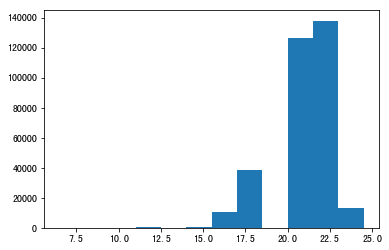

In [9]:
# 借款利率的分布
bin_edges = np.arange(df_lc_clean['借款利率'].min(), df_lc_clean['借款利率'].max()+1.5, 1.5)
plt.hist(df_lc_clean['借款利率'], bins=bin_edges);

> 借款利率呈单峰分布，大多在20-22.5之间。

### 借款金额

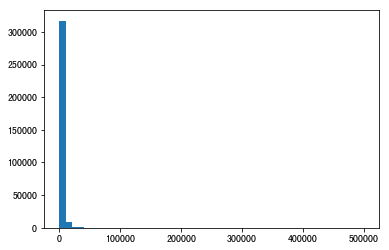

In [10]:
bin_edges = np.arange(0, df_lc_clean['借款金额'].max()+10000, 10000)
plt.hist(df_lc_clean['借款金额'], bins=bin_edges);

(array([     0.,      0.,      0.,      0.,      0.,      0.,    849.,
         1495.,  12778.,  34428.,  62775., 130293.,  74464.,   9032.,
         1523.,    388.,    205.,    189.,    134.]), array([0.1, 0.4, 0.7, 1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7,
       4. , 4.3, 4.6, 4.9, 5.2, 5.5, 5.8]), <a list of 19 Patch objects>)


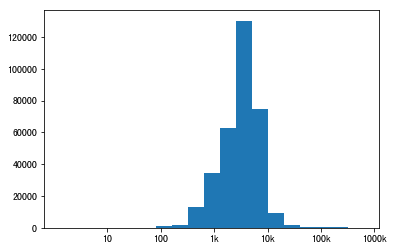

In [11]:
# log变换(10为底)
def trans(x, inverse = False):
    if not inverse: return np.log10(x)
    else: return 10 ** x
# 创建log变换后的数据
df_lc_clean['log_借款金额'] = df_lc_clean['借款金额'].apply(trans)
# 绘制log处理后数据的直方图
bin_edges = np.arange(0.1, df_lc_clean['log_借款金额'].max()+0.3, 0.3)
ax = plt.hist(df_lc_clean['借款金额'].apply(trans), bins = bin_edges)
print(ax)
tick_locs = pd.Series([10, 100, 1000, 10000, 100000, 1000000]).apply(trans)
plt.xticks(tick_locs, [10,100,'1k','10k','100k','1000k']);

> 第一张图借款金额有长尾。当使用log缩放后，分布呈现单峰分布，大多数金额在1200-10000之间。

### 逾期率

(array([2.97248e+05, 1.36230e+04, 8.22600e+03, 3.82500e+03, 1.69600e+03,
        2.36000e+03, 7.24000e+02, 3.15000e+02, 2.27000e+02, 3.09000e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

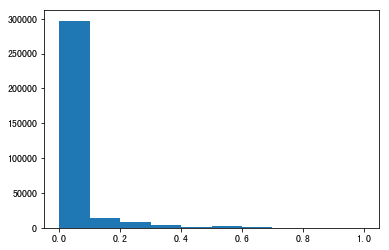

In [12]:
plt.hist(df_lc_clean['逾期率'])

> 逾期率呈右偏分布，逾期率大多在0-0.1之间。

### 借款期限

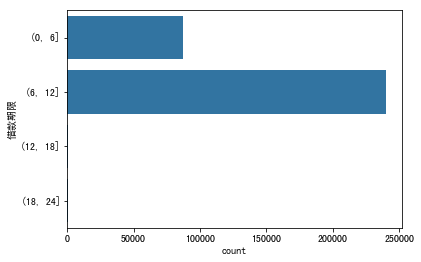

In [13]:
base_color = sb.color_palette()[0]
sb.countplot(data = df_lc_clean, y = '借款期限', color = base_color);

> 借款期限大多在6-12个月。

### 初始评级

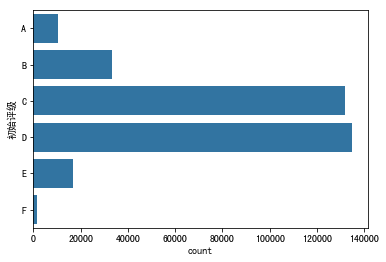

In [14]:
sb.countplot(data = df_lc_clean, y = '初始评级', color = base_color);

> 初始评级大多是C或D。

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

- 借款利率呈单峰分布，大多在20-22.5之间。
- 借款金额有长尾。当使用log缩放后，分布呈现单峰分布，大多数金额在1200-10000之间。
- 从可视化来看所有变量没有异常值。

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

- 从可视化看各个变量没有异常，没有对数据做更改。

## Bivariate Exploration

开始探索变量之间的相关性

### 探索借款金额，借款利率，逾期率

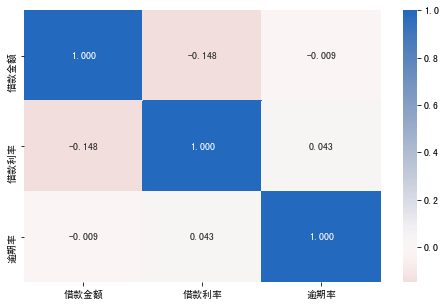

In [15]:
# 给这些变量绘制相关系数矩阵
numeric_vars = ['借款金额', '借款利率', '逾期率']
plt.figure(figsize = [8, 5])
# 使用发散色板 cmap = 'vlag_r'
sb.heatmap(df_lc_clean[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0)
plt.show()

> 借款金额，借款利率，逾期率三个变量没有明显的相关性。

### 探索借款利率和初始评级

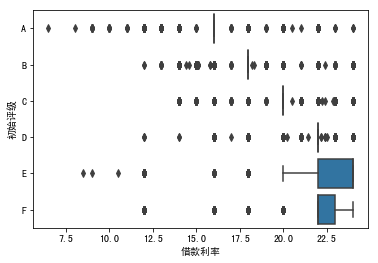

In [16]:
# 绘制分类和数值变量
base_color = sb.color_palette()[0]
sb.boxplot(data = df_lc_clean, x = '借款利率', y = '初始评级', color = base_color);

> 初始评级和借款利率有负相关性，初始评级低的借款利率集中位置比初始评级高的借款利率集中位置大。需要注意的是初始评级高的记录里边也有借款利率高的。

### 探索借款利率和借款期限

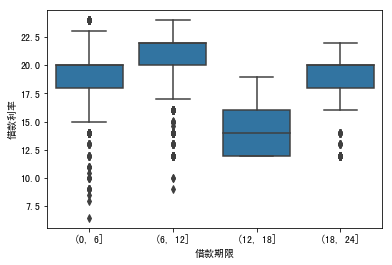

In [17]:
# 绘制log数据
# sb.violinplot(data = df_lc_clean, x = '借款期限', y = '借款利率', color = base_color);
sb.boxplot(data = df_lc_clean, x = '借款期限', y = '借款利率', color = base_color);

> 借款利率和借款期限没有明显规律

### 探索逾期率和初始评级

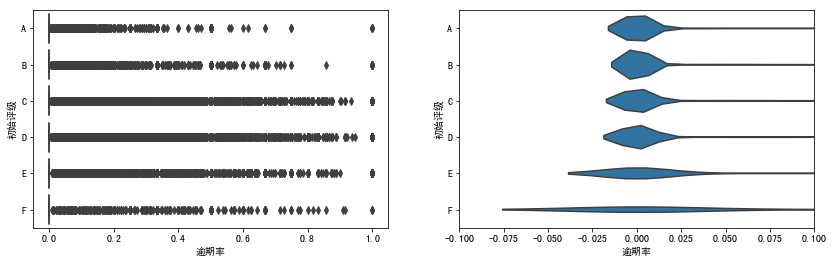

In [18]:
# 绘制分类和数值变量
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
base_color = sb.color_palette()[0]
plt.sca(axes[0])
sb.boxplot(data = df_lc_clean, x = '逾期率', y = '初始评级', color = base_color)
plt.sca(axes[1])
sb.violinplot(data = df_lc_clean, x = '逾期率', y = '初始评级', color = base_color, inner = None)
plt.xlim(-0.1,0.1);

> 和初始评级低的比，初始评级高的逾期率分布在0处更集中。需要注意的是初始评级高的记录中也有高逾期率的。

### 探索借款金额和初始评级

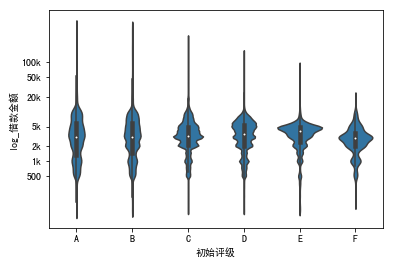

In [19]:
# 绘制分类和数值变量
# 绘制借款金额的log变换数据
sb.violinplot(data = df_lc_clean, x = '初始评级', y = 'log_借款金额', color = base_color)
plt.yticks(trans(np.array([500, 1e3, 2e3, 5e3, 2e4, 5e4, 1e5])), [500, '1k', '2k', '5k', '20k','50k', '100k']);

> 借款金额和初始评级没有明显规律。

### 探索借款金额和借款期限

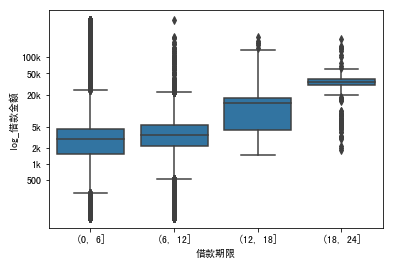

In [20]:
# 绘制借款金额的log变换数据
# sb.violinplot(data = df_lc_clean, x = '借款期限', y = 'log_借款金额', color = base_color)
sb.boxplot(data = df_lc_clean, x = '借款期限', y = 'log_借款金额', color = base_color);
plt.yticks(trans(np.array([500, 1e3, 2e3, 5e3, 2e4, 5e4, 1e5])), [500, '1k', '2k', '5k', '20k','50k', '100k']);

> 借款期限和借款金额有正相关性，好像借款期限高的借款金额也高。

### 探索逾期率和借款期限

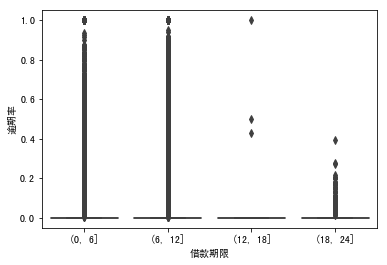

In [21]:
# sb.violinplot(data = df_lc_clean, x = '借款期限', y = '逾期率', color = base_color);
sb.boxplot(data = df_lc_clean, x = '借款期限', y = '逾期率', color = base_color);

> 逾期率和借款期限没有明显规律。

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

初始评级影响借款利率，初始评级好的借款利率集中位置比初始评级差的借款利率集中位置小。

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

逾期率影响初始评级，初始评级好的在0附近的概率比初始评级差的大。

## Multivariate Exploration

探索除了初始评级，还有什么变量影响借款利率。

### 探索逾期率，初始评级，借款利率的关系

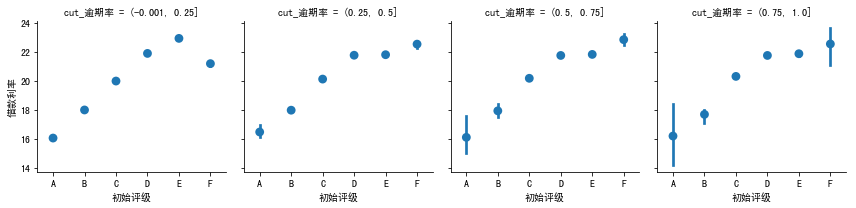

In [22]:
# 将逾期率分箱
bins = [0, 0.25, 0.5, 0.75, 1]
df_lc_clean['cut_逾期率'] = pd.cut(df_lc_clean['逾期率'], bins, include_lowest=True)
# 绘制每个分箱的评级和借款利率
g = sb.FacetGrid(data = df_lc_clean, col = 'cut_逾期率')
g.map(sb.pointplot, '初始评级', '借款利率', linestyles = "", order=['A','B','C','D','E','F']);

> 初始评级高和借款利率负相关，然而逾期率对借款利率没有直接影响。

### 探索借款金额，初始评级，借款利率的关系

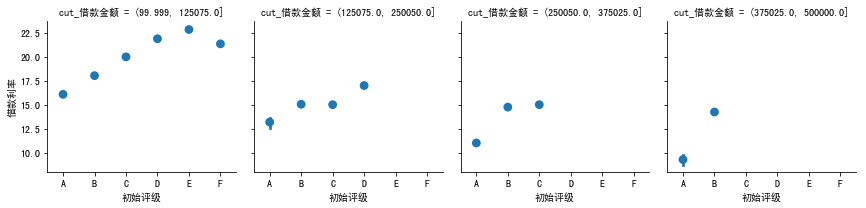

In [23]:
bins = np.linspace(df_lc_clean['借款金额'].min(), df_lc_clean['借款金额'].max(), 5)
df_lc_clean['cut_借款金额'] = pd.cut(df_lc_clean['借款金额'], bins, include_lowest=True)
g = sb.FacetGrid(data = df_lc_clean, col = 'cut_借款金额')
g.map(sb.pointplot, '初始评级', '借款利率', linestyles = "", order=['A','B','C','D','E','F']);

> 初始评级高和借款利率有负相关。随着借款金额的上升，借款利率好像在降低

### 探索借款期限，初始评级，逾期率的关系

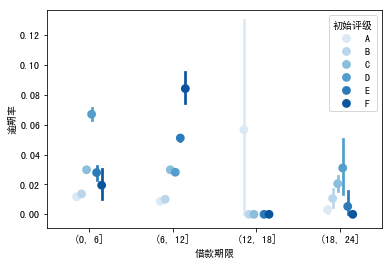

In [24]:
# 绘制探索借款期限，初始评级，逾期率的关系
plt.figure(figsize = [6, 4])
sb.pointplot(data = df_lc_clean, x = '借款期限', y = '逾期率', hue = '初始评级',
             dodge = 0.3, linestyles = "",palette = 'Blues');

> 初始评级在借款期限是6-12月的记录中，呈现出初始评级越差逾期率越大的趋势。

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

- 初始评级越高借款利率越低在借款利率的平均值中趋势更加明显。
- 借款金额也对借款利率有影响，好像借款金额约高借款利率越低。

### Were there any interesting or surprising interactions between features?

- 逾期率影响了初始评级，初始评级影响了借款利率，但是逾期率和借款利率没有明显关系。
